# 商务案例: 电影推荐
# 1. 数据集与SurPRISE库
## 1.1. MovieLens 100K
**MovieLens**数据集是从网站MovieLens (http://movielens.org) 所收集的真实用户评分数据。其中的[`ml-100k`](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt)是从1997-9-19至1998-4-22期间约7个月的数据，本次案例将选取其中`u.data`文件，该文件包含由943个用户对于1682部影片的共100,000条评分记录，并保证每个用户至少有20条评分记录，其中的评分对应1、2、3、4、5五个等级。数据字段如下：

| user id | item id | rating | timestamp |
|---------|---------|--------|-----------|

## 1.2. SurPRISE
[SurPRISE](http://surpriselib.com/)（Simple Python RecommendatIon System Engine）是Python的一个能够建立推荐系统并实施分析、处理**显式**评分数据的第三方库。Surprise既提供了许多内置的数据集（[Movielens](https://grouplens.org/datasets/movielens/)、[Jester](http://eigentaste.berkeley.edu/dataset/)），也能让用户构建自己的数据集，并搭建了众多常见的推荐算法与分析工具。

In [1]:
# 用pip安装surprise库
# pip install scikit-surprise

In [25]:
import os
import pandas as pd

from surprise import accuracy
from surprise import Dataset
from surprise import KNNBasic, KNNWithMeans
from surprise import SVD
from surprise.model_selection import KFold, LeaveOneOut, train_test_split
from surprise.model_selection import GridSearchCV

# 2. 数据探索分析
## 2.1. 数据载入
在Surprise中，已自带`ml-100k`数据集，可直接函数[`Dataset.load_builtin`](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin)导入（第一次导入需要下载数据集）。

In [26]:
data = Dataset.load_builtin('ml-100k')

此外，若要导入非自带的数据集，Surprise也提供了导入的方法。例如对于pandas的DataFrame，也有对应的方法[`load_from_df()`](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_from_df)，具体可参考[官方文档](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset)。
## 2.2. 数据分析
将`data`直接转化为表格形式较为麻烦，这里直接用`pandas`库读取数据集中的`u.data`文件。

In [16]:
file_path = os.path.expanduser('~/.surprise_data/ml-100k/ml-100k/u.data')
df = pd.read_csv(file_path, sep='\t', names=['user', 'item', 'rating', 'timestamp'])
df.sample(6, random_state=1)

,user,item,rating,timestamp
43660,508,185,5,883777430
87278,518,742,5,876823804
14317,178,28,5,882826806
81932,899,291,4,884122279
95321,115,117,4,881171009
5405,91,682,2,891438184


In [27]:
print('------数据集规模------')
print('用户数：', len(df.user.unique()))
print('电影数：', len(df.item.unique()))
print('评分数：', len(df))
print(f'稀疏度：{1 - len(df) / len(df.user.unique()) / len(df.item.unique()):.2%}')

------数据集规模------
用户数： 943
电影数： 1682
评分数： 100000
稀疏度：93.70%


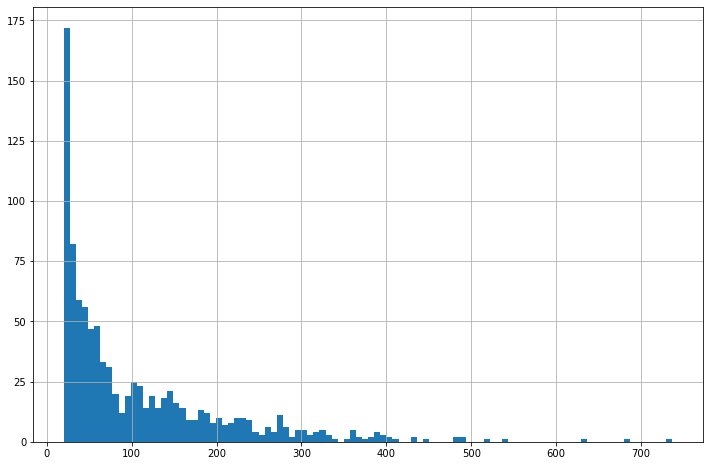

In [28]:
# 用户点评电影频次分布直方图
df.groupby(by='user')['item'].count().hist(bins=100, figsize=(12, 8))

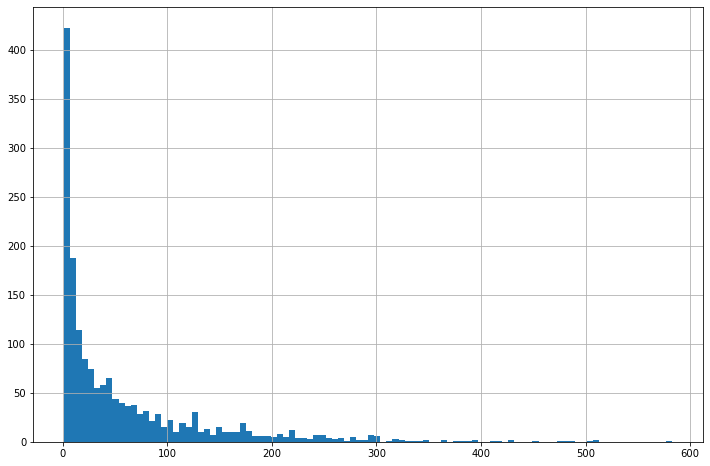

In [29]:
# 电影被用户点评频次分布直方图
df.groupby(by='item')['user'].count().hist(bins=100, figsize=(12, 8))

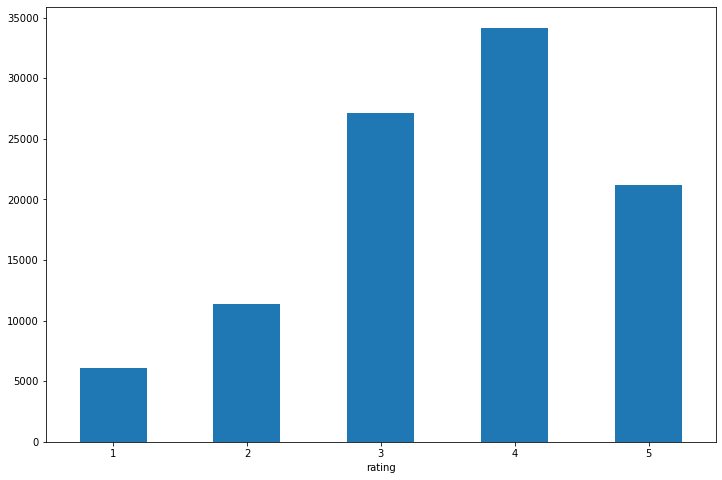

In [30]:
# 电影评分大小分布图
df.groupby(by='rating')['user'].count().plot(kind='bar', figsize=(12, 8), rot=0)

# 3. 评估指标
本次分析用到两个指标`RMSE`（均方根误差）与`MAE`（平均绝对误差），两个方法都已经实现于[`accuracy`](https://surprise.readthedocs.io/en/stable/accuracy.html)模块中，即
> ```python
> surprise.accuracy.rmse(predictions, verbose=True)
> surprise.accuracy.mae(predictions, verbose=True)
> ```

这些方法的返回值为指标计算结果。对于输入的两个参数：`predictions`根据具体算法类中的`test()`方法得到；`verbose`决定是否格式化输出指标结果。

# 4. 数据集划分
在推荐模型的训练与评估中，我们往往需要将数据集拆分成训练集与测试集。Surprise已在`surprise.model_selection`模块中，以**迭代器**（iterator）的形式构建了常见的交叉验证类，此外也有随机划分的方法。

关于迭代器：尽管我们能用方法[`cross_validate()`](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.validation.cross_validate)实现交叉验证，但通过实例化每一次交叉验证迭代器、并结合方法`split()`，可以实现更好地控制每一次验证。
## 4.1. 交叉验证法
交叉验证对于数据量较小的数据集比较实用。它的思路简要来说是将数据集分为k份，每次将其中k-1作为训练集、剩下一份作为测试集，一共进行k次。对应Surprise中的[`KFold`](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.split.KFold)类，其中传入三个参数：
> - `n_splits`：默认为5，交叉验证的折数（k）.
> - `random_state`：默认为None，随机数种子。
> - `shuffle`：默认为True，是否将数据集打乱后再拆分。

In [19]:
kf = KFold(n_splits=3, random_state=1)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)
print('测试集大小: ', len(testset))
print('测试集用户数：', len(set([x[0] for x in testset])))

RMSE: 0.9391
RMSE: 0.9465
RMSE: 0.9444
测试集大小:  33333
测试集用户数： 943


## 4.2. 留一法
[`LeaveOneOut`](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.split.LeaveOneOut)是Surprise提供的一种特殊的交叉验证类，它拆分出的测试集中**每个用户**都有且仅有一条评分记录。

> 这里的拆分不同于通常的留一法（例如，sklearn的[LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn-model-selection-leaveoneout)）测试集仅保留一条记录、并对完整数据的每一条记录都作为测试集进行一次交叉验证。Surprise库的LeaveOneOut测试集数目与用户数相同，且可以指定折数（而不是一定等于数据集大小）。

用到的参数如下：
> - `n_splits`：默认为5，交叉验证的折数。
> - `random_state`：默认为None，随机数种子。
> - `min_n_ratings`：默认为0，训练集中用户至少具有的评分数，少于min_n_ratings的用户将从训练集删除。

In [18]:
loo = LeaveOneOut(n_splits=3, random_state=1)
algo = SVD()

for trainset, testset in loo.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)
print('测试集大小: ', len(testset))
print('测试集用户数：', len(set([x[0] for x in testset])))

RMSE: 1.0131
RMSE: 0.9318
RMSE: 0.9636
测试集大小:  943
测试集用户数： 943



## 4.3. 随机划分法
当数据量足够模型训练时，往往仅需要进行一次随机划分即可，对应Surprise中实现的方法[`train_test_split()`](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.split.train_test_split)（这里不是迭代器）。

主要用到三个参数:	
> - `data`：需要拆分的数据集。
> - `test_size`：默认为0.2，传入为`float`表示测试集占原始数据的比例，传入为`int`时为测试集大小。
> - `random_state`：默认为None，随机数种子。

该函数将最终同时返回训练集(surprise.trainset.Trainset)与测试集(list)。

In [9]:
# 测试集将占总数据的25%
trainset, testset = train_test_split(data, test_size=.25, random_state=1)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print('训练集大小：%d，测试集大小：%d' %(trainset.n_ratings, len(testset)))

RMSE: 0.9415
MAE:  0.7407
训练集大小：75000，测试集大小：25000


# 5. 推荐算法对比

In [10]:
rmse = dict()
mae = dict()

## 5.1. 基于近邻的协同过滤
#### 5.1.1. 相似度衡量

根据实际情况的需要，我们需要设置不同的相似度指标应用于对应近邻方法，在Surprise库中，需要做的则是构建近邻算法时传入参数[`sim_options`](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)，该参数以字典形式主要用到如下键值：
> - [`'name'`](https://surprise.readthedocs.io/en/stable/similarities.html#module-surprise.similarities)：默认为`'MSD'`，使用的相似度指标，常用的有`'MSD'`（均方距离）、`'cosine'`（cosine相似度）。
> - `'user_based'`：默认为True，此时计算用户之间的相似度；否则计算电影之间的相似度。
> - `'min_support'`：默认为1，（user_base为True时）若用户u与用户v间共同评分的电影数小于min_support时，$\text{sim}(u, v)=0$

例如我们可以如下定义:
```python
# 计算电影之间的cosine相似度
sim_options = {
    'name': 'cosine',
    'user_based': False,
    'min_support': 5,
}
```

### 5.1.2. itemKNN
基于item的协同过滤，通过计算不同item（如电影）之间的相似度，进而对用户$u$关于电影$j$的评分预测。在给定电影$j$的近邻$N_j$时，公式为
$$
\hat{r}_{uj} = \frac{\sum_{i\in N_j}\text{sim}(i, j) \times r_{ui}}
                    {\sum_{i\in N_j}\text{sim}(i, j)}
$$
Surprise中的[`KNNBasic`](https://surprise.readthedocs.io/en/stable/knn_inspired.html?highlight=knn#surprise.prediction_algorithms.knns.KNNBasic)对该模型进行实现，用到的参数如下:
> - `k`：默认值为40，近邻的最大数量。
> - `min_k`：默认值为1。考虑近邻数不够时（$|N_j|<\text{min_k}$），预测值为整体均值。
> - `sim_options`（dict）：相似度参数设置，详见[sim_options](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)。
> - `verbose`（bool）：默认为True，是否输出详细信息。

> **注**：此时`sim_options`的`'user_based'`必须为False！

In [31]:
sim_options = {
    'name': 'cosine',
    'user_based': False,  # 基于item时必须为False!
}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

rmse['itemKNN'] = accuracy.rmse(predictions)
mae['itemKNN'] = accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0349
MAE:  0.8204


### 5.1.3. userKNN
基于用户的协同过滤，通过计算用户之间的相似度来预测用户对电影的评分，并且考虑不同个体平均评分$\bar{r}_u$的影响，一定程度上能反应不同用户的打分偏好的高低。具体来说，基于userKNN的偏好评分预测公式为：
$$
\hat{r}_{uj} = \bar{r}_u + \frac{\sum_{v\in N_u}\text{sim}(u,v) \times (r_{vj} - \bar{r}_v)}
                                {\sum_{v\in N_u}\text{sim}(u, v)}
$$
[`KNNWithMeans`](https://surprise.readthedocs.io/en/stable/knn_inspired.html?highlight=knn#surprise.prediction_algorithms.knns.KNNWithMeans)实现了考虑评分均值的KNN，用到的参数与`KNNBasic`相同。同样的，此时`sim_options`的`'user_based'`必须为True！


In [32]:
sim_options = {
    'name': 'cosine',
    'user_based': True,  # 基于user时必须为True!
}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

rmse['userKNN'] = accuracy.rmse(predictions)
mae['userKNN'] = accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9610
MAE:  0.7579


## 5.2. 基于矩阵分解的协同过滤
矩阵分解的方法对应Surprise已经实现对应的类[SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)。通过随机梯度下降(SGD)对下述目标函数进行优化：
$$
\min_{p,q,b}\sum_{r_{ui}\in R_{train}}\left [(r_{ui} - \hat{r}_{ui})^2 + \lambda(b_i^2 + b_u^2 + \left \| p_u \right \|^2  + \left \| q_i \right \| ^ 2 )\right ]
$$
不考虑偏置项$b_i$、$b_u$时，此时预测$\hat{r}_{ui}=q_i^\top p_u$，模型转化为MF（Matrix Factorization）。

主要用到的参数有:	
> - `n_factors`：默认为100，$q_i$、$p_u$的维度。
> - `n_epochs`：默认为20，SGD过程的迭代次数。
> - `biased`：默认为True，是否引入偏置项。当biased为False时转化为MF模型。
> - `init_mean`：默认为0，各参数初始化时（正态）分布的均值。
> - `init_std_dev`：默认为0.1，各参数初始化时（正态）分布的标准差。
> - `lr_all`：默认为0.005，SGD时所用的学习率。
> - `reg_all`：默认为0.02，正则项的系数$\lambda$。
> - `random_state`：默认为None，模型的随机数种子。
> - `verbose` – 默认为False，是否输出Epoch迭代情况。

In [33]:
# 5.2.1.SVD: (biased=True)
algo = SVD(random_state=1)
algo.fit(trainset)
predictions = algo.test(testset)

rmse['SVD'] = accuracy.rmse(predictions)
mae['SVD'] = accuracy.mae(predictions)

RMSE: 0.9454
MAE:  0.7463


In [34]:
# 5.2.2.MF: (biased=False)
algo = SVD(biased=False, random_state=1)
algo.fit(trainset)
predictions = algo.test(testset)

rmse['MF'] = accuracy.rmse(predictions)
mae['MF'] = accuracy.mae(predictions)

RMSE: 0.9617
MAE:  0.7595


In [36]:
metrics_df = pd.DataFrame({'RMSE': rmse, 'MAE': mae})
metrics_df

,RMSE,MAE
itemKNN,1.034911,0.820358
userKNN,0.961010,0.757864
SVD,0.945420,0.746290
MF,0.961665,0.759512



# 6. 参数调节
调参常用的方法为*网格搜索*，主要思想是根据不同的参数组合寻找性能最优的参数。Surprise中的[`GridSearchCV`](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.search.GridSearchCV)通过提供的参数可能`param_grid`，用交叉验证的方法计算出对于算法`algo_class`的最优参数组合。

常用的参数有：
> - algo_class（AlgoBase）：待检测的算法类。
> - param_grid（dict）：需要测试的参数与对应的可能值（list）。
> - measures：默认为`['rmse', 'mae']`，模型衡量的指标。
> - cv：交叉验证的折数，默认进行5折交叉验证。
> - n_jobs：默认为1，并行训练数目，实现加速运算。

以SVD为例，如果我们想尝试寻找`n_epochs`、`lr_all`和`reg_all`，则将所用到的参数名和参数值存放在字典`param_grid`中。例如，对于
```python
param_grid = {
    'n_epochs': [5, 10],
    'lr_all': [0.001,  0.01, 0.02],
    'reg_all': [0.04, 0.08],
}
```
将运算$2\times3\times2=12$种参数组合。

In [37]:
param_grid = {
    'n_epochs': [5, 10],
    'lr_all': [0.001,  0.01, 0.02],
    'reg_all': [0.04, 0.08],
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=4)
gs.fit(data)

In [38]:
print('对于RMSE：')
print('最好分数：', gs.best_score['rmse'])
print('对应参数：', gs.best_params['rmse'])
print('对于MAE：')
print('最好分数：', gs.best_score['mae'])
print('对应参数：', gs.best_params['mae'])

对于RMSE：
最好分数： 0.9282924339049193
对应参数： {'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0.08}
对于MAE：
最好分数： 0.7340437936342292
对应参数： {'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0.08}


In [43]:
# 可以利用best_estimator获取最好模型
algo_rmse = gs.best_estimator['rmse']
algo_mae = gs.best_estimator['mae']